In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager

def bigprint(*args, font_size="2em"):
    """Prints the arguments using a larger font so Kanji are easier to read."""
    import IPython.core.display
    html = '<div style="font-family: TakaoGothic; font-size: %s; line-height: 1.5">' % font_size + ' '.join(args) + '</div>'
    IPython.core.display.display(IPython.core.display.HTML(html))
    
def demo(function):
    """Decorates the function to show the input parameters and the return value."""
    def inner(*args, **kwargs):
        retval = function(*args, **kwargs)
        bigprint('%s %r %r --> %r' % (function.__name__, args, kwargs, retval))
        return retval
    return inner

#
# Getting Japanese fonts to work with Networkx can bit a little tricky.
#
# https://qiita.com/grachro/items/4c9b03366cae2df3a301
# https://linuxfan.info/ubuntu-18-04-change-ja-font
# https://showa-yojyo.github.io/notebook/python-networkx/drawing.html 
#
fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
jp_fonts = [f for f in fonts if 'takaogothic' in f.lower()]
print(jp_fonts)
jp_prop = matplotlib.font_manager.FontProperties(fname=jp_fonts[0])
jp_prop.set_size(40)

['/usr/share/fonts/truetype/takao-gothic/TakaoGothic.ttf']


# Heisig

In [2]:
# ! wget http://ziggr.com/heisig/heisig-data.txt.gz

In [3]:
# The Heisig method assigns keywords to Kanji, and groups Kanji into lessons of increasing difficulty.
import csv
import gzip
import io
import pprint

def tweak(kanji):
    kanji.pop('keyword3rd-ed')
    kanji.pop('keyword4th-ed')
    kanji['keyword'] = kanji.pop('keyword5th-ed')
    for key, value in kanji.items():
        if value.isdigit():
            kanji[key] = int(value)
    return dict(kanji)

with gzip.GzipFile('heisig-data.txt.gz') as fin:
    fin.readline()
    reader = csv.DictReader(io.StringIO(fin.read().decode('utf-8')), delimiter=':')
    heisig = [tweak(x) for x in reader]
    
heisig_dict = {k['kanji']: k for k in heisig}
pprint.pprint(heisig_dict['鉄'])

{'#heisignumber': 846,
 'indexordinal': 1626,
 'kanji': '鉄',
 'keyword': 'iron',
 'lessonnumber': 25,
 'strokecount': 13}


In [4]:
bigprint('鉄', heisig_dict['鉄']['keyword'])
bigprint('金', heisig_dict['金']['keyword'])
bigprint('失', heisig_dict['失']['keyword'])

In [5]:
# One catch: Heisig only covers a subset of the Kanji.
# These are the most commonly used Kanji, so it's a _good_ subset.
len(heisig)

2042

In [6]:
def lrange(*args):
    return list(range(*args))

def from_stroke_count(*counts):
    """Return the list of Kanji that have the specified stroke count."""
    for k in heisig:
        if k['strokecount'] in counts:
            yield k['kanji']
            
bigprint(*list(from_stroke_count(13))[:10])

In [7]:
bigprint(*list(from_stroke_count(1, 10))[:10])

In [8]:
bigprint(*list(from_stroke_count(*lrange(1, 3))))

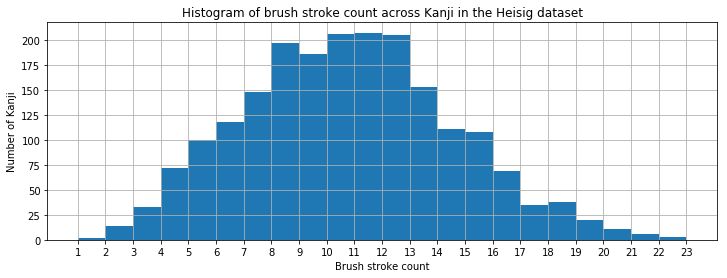

In [9]:
def plot_hist(counts):
    bins = list(range(1, max(counts) + 1))
    plt.figure(figsize=(12, 4))
    plt.hist(counts, bins=bins)
    plt.xticks(bins)
    plt.grid();
    
plot_hist([k['strokecount'] for k in heisig])
plt.title('Histogram of brush stroke count across Kanji in the Heisig dataset')
plt.ylabel('Number of Kanji')
plt.xlabel('Brush stroke count');

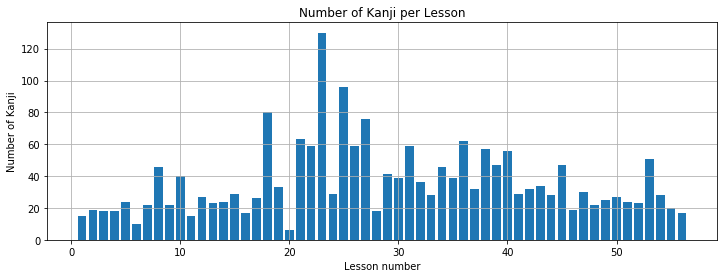

In [10]:
import collections

kanji_per_lesson = collections.defaultdict(int)
for kanji in heisig:
    kanji_per_lesson[int(kanji['lessonnumber'])] += 1
x = sorted(kanji_per_lesson.keys())
y = [kanji_per_lesson[xx] for xx in x]
plt.figure(figsize=(12, 4))
plt.bar(x, y)
plt.grid()
plt.xlabel('Lesson number')
plt.ylabel('Number of Kanji')
plt.title('Number of Kanji per Lesson');

In [11]:
heisig_lesson = {
    lesson: ''.join([k['kanji'] for k in heisig if int(k['lessonnumber']) == lesson])
    for lesson in kanji_per_lesson
}
bigprint(heisig_lesson[3])
bigprint(heisig_lesson[2])
bigprint(heisig_lesson[3])

In [12]:
# Our memory is not perfect, so it's convenient to go between keywords and Kanji quickly
to_keyword = {h['kanji']: h['keyword'] for h in heisig_dict.values()}
bigprint(to_keyword['旭'])

In [13]:
from_keyword = {h['keyword']: h['kanji'] for h in heisig_dict.values()}
bigprint(from_keyword['rising sun'])

In [14]:
# Short names for convenience
fkw = from_keyword
tkw = to_keyword

# KRAD

In [15]:
# Simplest way to acquire the file is with wget, if you're in a GNU environment.
#
# ! wget ftp://ftp.monash.edu/pub/nihongo/kradfile.gz

In [16]:
import gzip
with gzip.GzipFile('kradfile.gz') as fin:
    krad = fin.read().decode('euc-jp')

for line in krad.split('\n')[110:120]:
    bigprint(line)

In [17]:
def parse_krad():
    for line in krad.split('\n'):
        if line and line[0] == "#":
            continue
        elif ' : ' in line:
            kanji, radicals = line.split(' : ')
            radicals = radicals.split(' ')
            yield kanji, radicals
        
krad_dict = dict(parse_krad())

# So now, we can get the radicals present in any Kanji.  Cool, huh?
bigprint(*krad_dict['鉄'])

In [18]:
# How many unique Kanji?
len(krad_dict)

6355

In [19]:
# What are the most common radicals?
import collections
radicals = collections.Counter()
for val in krad_dict.values():
    radicals.update(val)

radicals.most_common(10)

[('口', 1340),
 ('一', 991),
 ('｜', 646),
 ('ノ', 626),
 ('木', 601),
 ('日', 593),
 ('ハ', 542),
 ('二', 476),
 ('土', 463),
 ('田', 461)]

In [20]:
# How many unique radicals are there?
len(radicals)

254

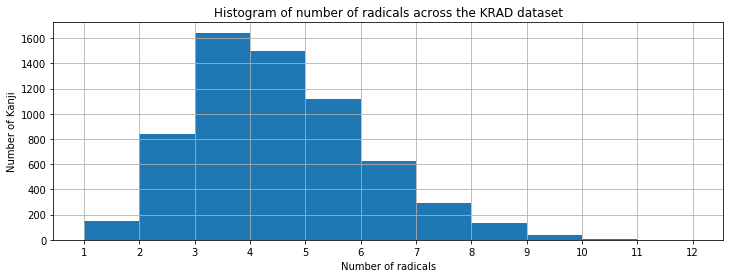

In [21]:
# How many radicals per Kanji?
plot_hist([len(radicals) for (kanji, radicals) in krad_dict.items()])
plt.title('Histogram of number of radicals across the KRAD dataset')
plt.ylabel('Number of Kanji')
plt.xlabel('Number of radicals');

In [22]:
# Can we measure similarity between two Kanji?
def find_common_radicals(k1, k2):
    """Return the common radicals between the two Kanji."""
    rad1 = set(krad_dict[k1])
    rad2 = set(krad_dict[k2])
    return rad1.intersection(rad2)

bigprint(*find_common_radicals('涼', '景'))

In [23]:
def find_similar_kanji(kanji, threshold=1):
    sim = sorted(
        ((len(find_common_radicals(kanji, k)), k) for k in krad_dict),
        reverse=True
    )
    return [k for (s, k) in sim if s > threshold and k != kanji]

bigprint('難')
bigprint(*find_similar_kanji('難', threshold=3))

In [24]:
# Are there Kanji that have the same radicals, but in different arrangements?
by_radicals = collections.defaultdict(list)
for kanji, radicals in krad_dict.items():
    key = tuple(sorted(set(radicals)))
    by_radicals[key].append(kanji)

for rad in sorted([" ".join(x) for x in by_radicals.values()], 
                  key=lambda item: len(item), reverse=True)[:20]:
    bigprint(*rad)

# CHISE (Character Information Service Environment)

In [25]:
# ! wget "http://git.chise.org/gitweb/?p=chise/ids.git;a=blob_plain;f=IDS-UCS-Basic.txt" -O IDS-UCS-Basic.txt

In [26]:
chise = open('IDS-UCS-Basic.txt', encoding='utf-8').read().rstrip()
for line in chise.split('\n')[20:30]:
    bigprint(line)

In [27]:
def parse_chise_ideographs(text):
    #
    # Each ideograph is either:
    # 
    #     1) A single character, where a character for the ideograph actually exists
    #     2) An escape code in the form of "&CDP-FFFF;", where FFFF is hex for the code.
    #
    while text:
        if text.startswith('&'):
            end = text.index(';')
            yield text[:end + 1]
            text = text[end + 1:]
        else:
            yield text[0]
            text = text[1:]
    
def parse_chise():
    for line in chise.split('\n')[1:]:
        code_point, kanji, ideographs = line.rstrip().split('\t', 2)
        yield kanji, list(parse_chise_ideographs(ideographs))
        
chise_dict = dict(parse_chise())
bigprint('鉄')
bigprint(*chise_dict['鉄'])

In [28]:
len(chise_dict)

20902

In [29]:
# Let's look at the available Kanji layouts.
# Recall that the first element in the ideograph list is the layout.
import collections
most_common = collections.Counter(ideo[0] for ideo in chise_dict.values()).most_common(12)
# most_common = collections.Counter(ideo[0] for kanji, ideo in chise_dict.items() if kanji in heisig_dict).most_common(12)
most_common

[('⿰', 14438),
 ('⿱', 4117),
 ('⿸', 694),
 ('⿺', 458),
 ('⿵', 218),
 ('⿳', 156),
 ('⿴', 138),
 ('⿹', 119),
 ('⿲', 51),
 ('⿷', 41),
 ('⿻', 14),
 ('⿶', 10)]

In [30]:
layouts = [layout for (layout, count) in most_common]
bigprint(*layouts)

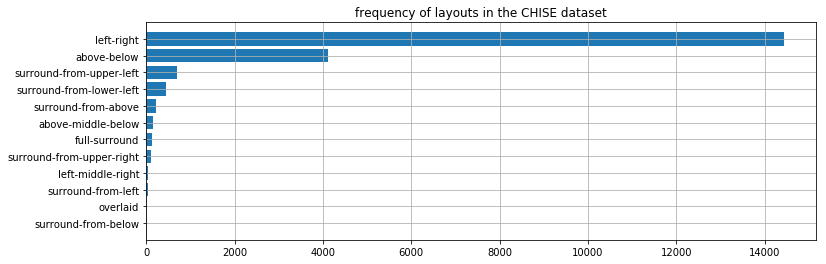

In [31]:
most_common_names = [            # For the purists, the Japanese equivalent is below:
    'left-right',                # hen/dzukuri
    'above-below',               # kanmuri/ashi
    'surround-from-upper-left',  # tare
    'surround-from-lower-left',  # nyou
    'surround-from-above',       # kamae (enclosing)
    'above-middle-below',        # ?
    'full-surround',             # kamae
    'surround-from-upper-right', # kamae
    'left-middle-right',         # ?
    'surround-from-left',        # kamae
    'overlaid',                  # ?
    'surround-from-below',       # kamae
]
#
# By far the most common layout is left-to-right, followed by top-and-bottom.
# The remaining layouts are far less common, which is possibly why the Japanese
# gave up trying to think up new names for them, and just called them all "kamae". 
#
# Let's plot the above, just because we can
#
most_common_count = [count for (layout, count) in most_common]
y_pos = list(reversed(range(len(most_common_count))))

plt.figure(figsize=(12, 4))
plt.barh(y_pos, most_common_count)
plt.yticks(y_pos, most_common_names)
plt.title('frequency of layouts in the CHISE dataset')
plt.grid();

In [32]:
def chise_decompose(kanji):
    """Decompose a Kanji as much as possible."""
    try:
        ideographs = chise_dict[kanji]
    except KeyError:
        return [kanji]
    if len(ideographs) == 1:
        return ideographs
    result = []
    for i in ideographs:
        result.extend(chise_decompose(i))
    return result

bigprint(*chise_decompose('恕'))

In [33]:
# You can also flip the mapping to go the other way around
import collections
inv_chise_dict = collections.defaultdict(list)
for kanji in chise_dict:
    for ideogram in chise_dict[kanji] + chise_decompose(kanji):
        inv_chise_dict[ideogram].append(kanji)

# This is particularly helpful when you know _part_ of a Kanji, but don't know the rest of it

In [34]:
# The above is so useful!  Let's generalize into a function
def chise_search(*parts):
    """Search for Kanji that contain all of the specified parts."""
    def tweak_parts():
        for p in parts:
            try:
                yield fkw[p]
            except KeyError:
                if len(p) != 1:
                    raise
                yield p
                
    parts = list(tweak_parts())
    
    first_part = parts.pop()
    candidates = set(inv_chise_dict[first_part])
    while parts:
        candidates = candidates.intersection(set(inv_chise_dict[parts.pop()]))
    return candidates

bigprint(*chise_search('heart', 'mouth', 'woman'))

In [35]:
bigprint("顳　鸚　爨　驪　纜　鱸　鸛", font_size="5em")

In [36]:
bigprint(*chise_search('耳', '頁'))

In [37]:
bigprint(*chise_search('ear', 'page'))

In [38]:
bigprint(*chise_search('woman', 'bird', 'shellfish'))

In [39]:
bigprint(*chise_search('tree', 'large', 'fire'))

In [40]:
bigprint(*chise_search('horse', 'deer'))

In [41]:
bigprint(*chise_search('thread', 'see'))

In [42]:
bigprint(*chise_search('fish', '虍'))

In [43]:
bigprint(*chise_search('bird', '艹'))

# Unleash the Graphs

In [44]:
def includes(first, second):
    """Return True if one of the Kanjis includes the other"""
    try:
        return first in chise_dict[second] or second in chise_dict[first] 
    except KeyError:
        return False

demo(includes)('止', '正')
demo(includes)('歩', '頻')
demo(includes)('宀', fkw['dormitory']);

In [45]:
chise_dict[fkw['walk']]

['⿱', '止', '少']

In [46]:
chise_dict['頻']

['⿰', '步', '頁']

In [47]:
import collections
import itertools
import networkx as nx

import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout, write_dot

def construct_graph(kanji_list, edge_function=includes):
    """Construct a graph that covers the specified Kanji.
    
    Automatically construct edges using the edge function.
    The edge function returns True for node pairs that should be connected.
    """
    G = nx.Graph()

    for k in kanji_list:
        try:
            keyword = heisig_dict[k]['keyword']
        except KeyError:
            keyword = ''
        G.add_node(k, keyword=keyword)

    for k1, k2 in itertools.combinations(kanji_list, 2):
        if edge_function(k1, k2):
            G.add_edge(k1, k2)
    return G

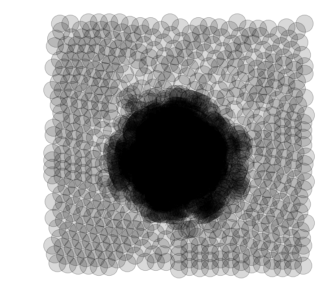

In [48]:
# Let's start by plotting a bird's eye view of the Heisig Kanji
def simple_plot(graph, figsize=(5, 5), alpha=0.5):
    """Show a simple plot of a Kanji graph.
    
    Does not show the actual Kanji or keywords, just nodes and edges.
    """
    fig, ax = plt.subplots(figsize=figsize)
    positions = graphviz_layout(graph, 'neato')
    node_color = [graph.nodes[n].get('color', 'black') for n in graph.nodes]
    nx.draw(graph, pos=positions, node_color=node_color, with_labels=False, alpha=alpha)
    return graph

G = construct_graph(heisig_dict, includes)
simple_plot(G, alpha=0.15);

In [49]:
# How many connected components are there?
clusters = list(nx.connected_components(G))
len(clusters)

428

In [50]:
# The largest connected component has over 1.5 thousand Kanji!
len(sorted(clusters, key=len, reverse=True)[0])

1551

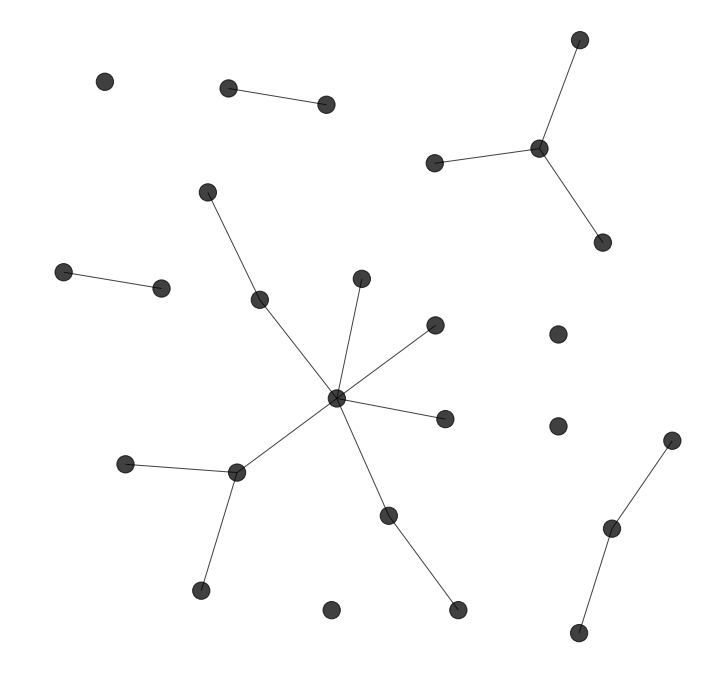

In [51]:
# The above visualization is not useful because the graph contains too many nodes/edges.
# We can use subgraphs to visualize parts of the larger graph.
# How do we select the nodes for the subgraph?
# Several options:
#
# - Heisig lesson (select nodes belonging to a particular lesson)
# - Radical (select nodes that have a particular radical)
# - Stroke count (select nodes that have a particular number of strokes)
# - Focus on a single node and explore a subgraph from it
# - Any others?
#
# Let's split the big graph by Heisig lesson, and look at lesson 17 as an example.
subgraph_kanji = heisig_lesson[17]
subgraph = G.subgraph(subgraph_kanji)
simple_plot(subgraph, figsize=(12, 12), alpha=0.75);

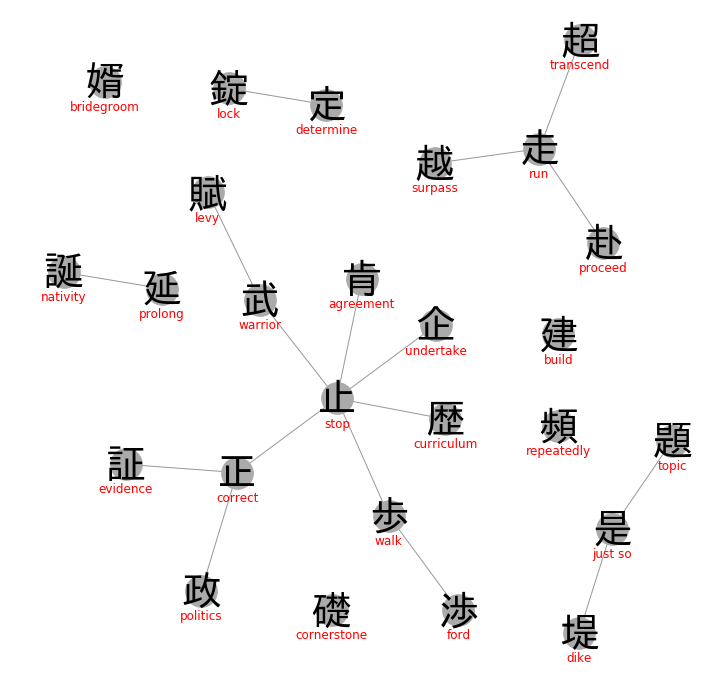

In [52]:
# OK, that looks manageable.  Let's add some labels.

def plot_graph(G, figsize=(12, 6), show_keywords=True, model='neato'):
    """Plot a graph using networkx and matplotlib.
    
    Labels each node with the Kanji, and optionally shows the Heisig keyword below each node.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    positions = graphviz_layout(G, model)
    
    nx.draw(G, pos=positions, with_labels=False, node_color='#aaaaaa', 
            node_size=1000, edge_color='#999999')
    label_positions = nx.draw_networkx_labels(G, positions)
    for text in label_positions.values():
        text.set_fontproperties(jp_prop)
        
    if show_keywords:
        #
        # Some magic to dynamically determine the proper offset for the label
        # https://stackoverflow.com/questions/43894987/networkx-node-labels-relative-position
        #
        renderer = fig.canvas.get_renderer()
        trans = plt.gca().transData.inverted()
        text = list(label_positions.values())[0]
        bounding_box = text.get_window_extent(renderer=renderer)
        bounding_box_data = bounding_box.transformed(trans)
        text_height = bounding_box_data.y1 - bounding_box_data.y0
        dy = 14 * text_height / 20
        
        keywords = {key: value['keyword'] for key, value in G.nodes().items()}
        keyword_positions = {k: (x, y - dy) for (k, (x, y)) in positions.items()}
        label_positions = nx.draw_networkx_labels(
            G, keyword_positions, labels=keywords, font_size=12, font_color='#ff0000'
        )
    plt.show()

plot_graph(subgraph, figsize=(12, 12))

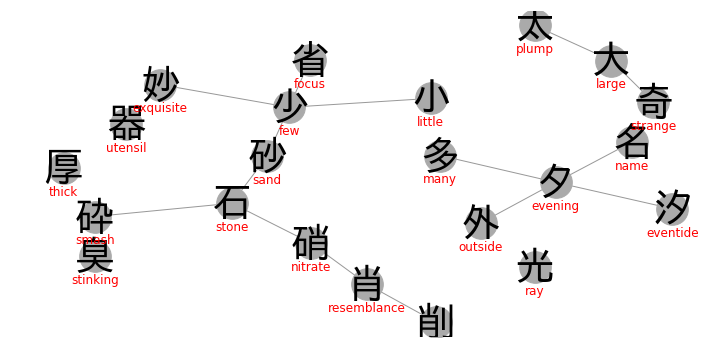

In [53]:
def extend_with_parts(kanji):
    #
    # Include relevant CHISE ideographs, except for escape codes
    #
    seen_parts = set()
    for k in kanji:
        try:
            parts = chise_dict[k]
        except KeyError:
            continue
        seen_parts |= set([p for p in parts if p not in layouts and len(p) == 1])
        
    for p in seen_parts:
        kanji.add(p)

        
def plot_heisig_lesson(*lesson_numbers, include_parts=False):
    kanji = set()
    for ln in lesson_numbers:
        kanji |= set(heisig_lesson[ln])
        
    if include_parts:
        extend_with_parts(kanji)
    
    G = construct_graph(kanji, includes)
    plot_graph(G, model='neato')
    
    return G

# We can easily plot any of the 52 lessons this way
lesson = plot_heisig_lesson(7)

In [54]:
kanji_set = set(heisig_dict)
extend_with_parts(kanji_set)
G = construct_graph(kanji_set, includes)
nx.write_yaml(G, 'graph.yml')

In [55]:
def search(graph, node, seen, depth=1000):
    """Recursively search for nodes reachable from the specified node within some number of hops.
    
    Populates the seen set with the reachable nodes.
    """
    seen.add(node)
    
    if depth == 0:
        return
    
    for _, n in graph.edges([node]):
        if n not in seen:
            search(graph, n, seen, depth - 1)
            
def explore(kanji, depth=2, model='neato'):
    """Construct a subgraph by starting a search from the specified Kanji, and plot it."""
    seen = set([kanji])
    search(G, kanji, seen, depth=depth)
    sub = G.subgraph(seen)
    plot_graph(sub, model=model)

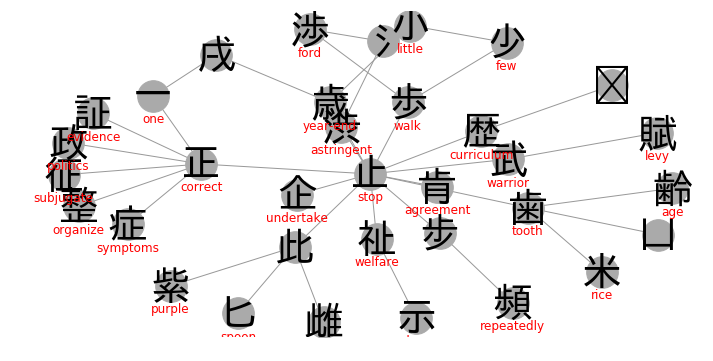

In [56]:
explore(fkw['stop'])

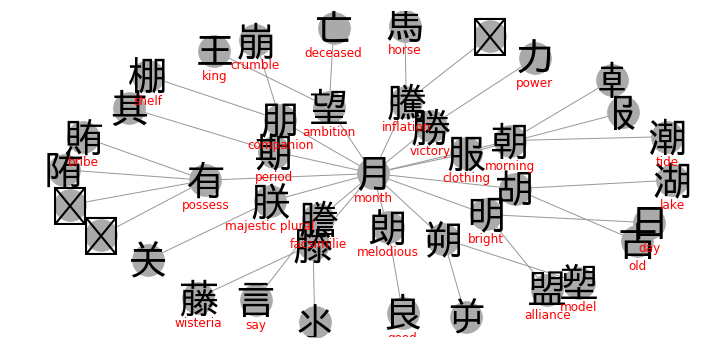

In [57]:
explore(fkw['month'])

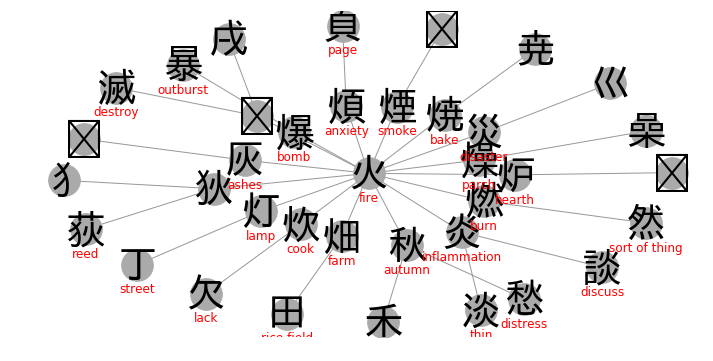

In [58]:
explore(fkw['fire'])

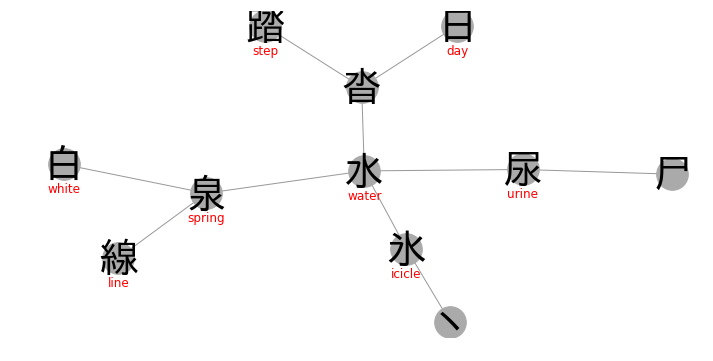

In [59]:
explore(fkw['water'])

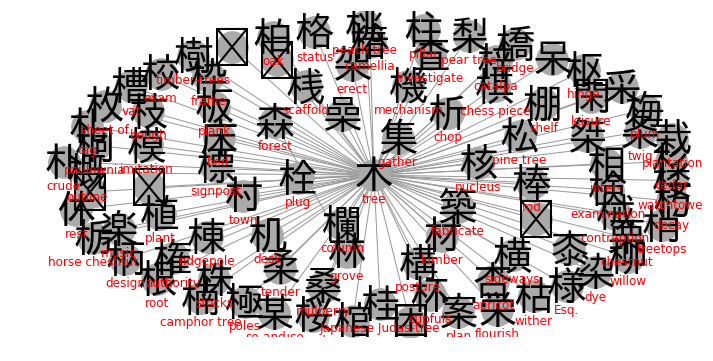

In [60]:
# Restricting the depth of the search reduces the number of nodes in the subgraph
explore(fkw['tree'], depth=1)

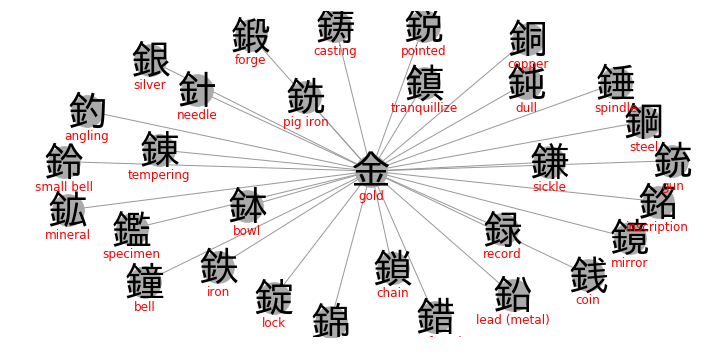

In [61]:
explore(fkw['gold'], depth=1)

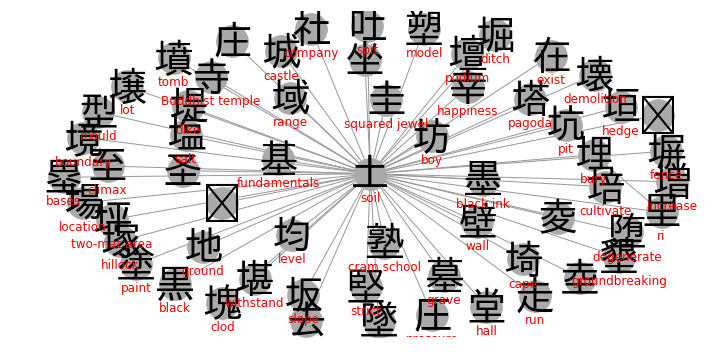

In [62]:
explore(fkw['soil'], depth=1)

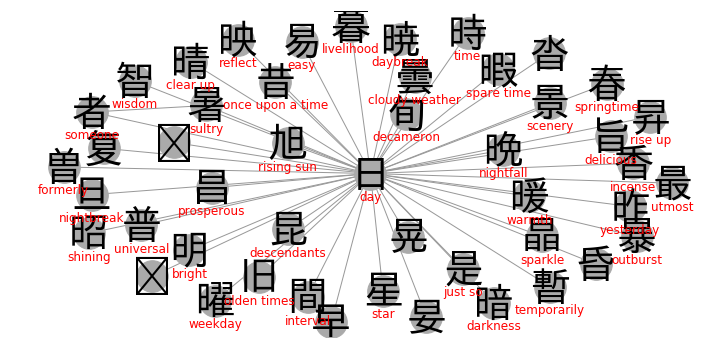

In [63]:
explore(fkw['day'], depth=1)

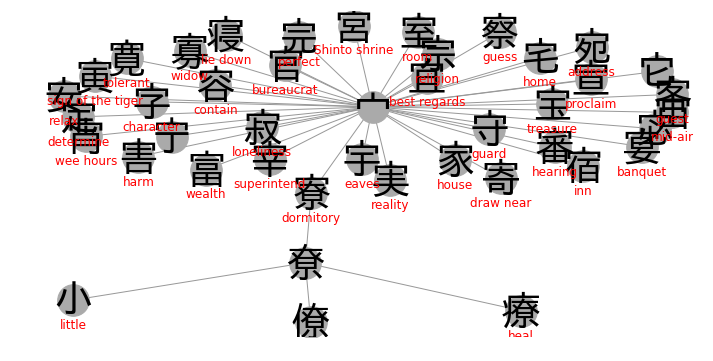

In [64]:
explore(fkw['dormitory'])

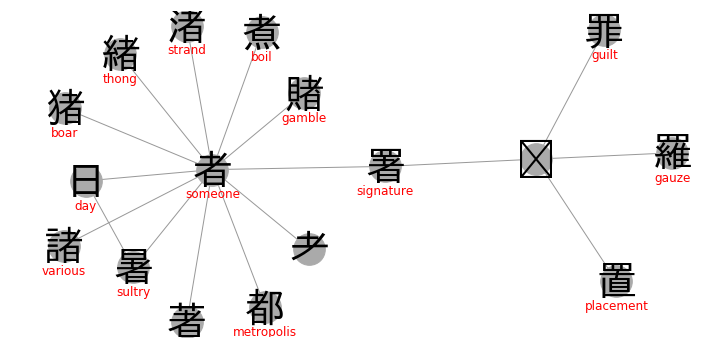

In [65]:
explore(fkw['signature'])

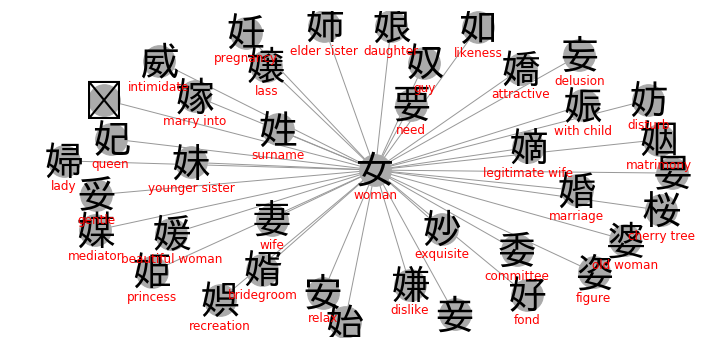

In [66]:
explore(fkw['woman'], depth=1)

In [67]:
clusters = list(nx.connected_components(G))
collections.Counter([len(c) for c in clusters])

Counter({1: 83, 2402: 1, 2: 2})

In [68]:
singletons = []
for c in clusters:
    if len(c) == 1:
        singletons.extend(c)
len(singletons)

83

In [69]:
bigprint("".join(singletons))

In [70]:
for s in singletons:
    try:
        ideograms = chise_dict[s]
    except KeyError:
        ideograms = []
    bigprint(s, ''.join(ideograms))

In [71]:
chise_dict['者']

['⿱', '耂', '日']

In [72]:
chise_dict['珍']

['⿰', '𤣩', '㐱']

In [73]:
chise_dict['競']

['⿰', '&CDP-8CFE;', '&CDP-8CFE;']

In [74]:
chise_dict['率']

['率']

In [75]:
chise_dict['徳']

['⿰', '彳', '&HD-TK-01032130;']